#Summary Statistics Regression Notebook 

In [1]:
#Import libraries 

#matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#pandas for working with dataframes
import pandas as pd 
from pandas import DataFrame, read_csv
#numpy
import numpy as np
#csv reader
import csv

import palettable as pal
from palettable.colorbrewer.qualitative import Paired_12

#for the linear regressions
from scipy import stats
import pylab

# Enable inline plotting
%matplotlib inline

/Users/eleanorbors/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module PIL was already imported from /Users/eleanorbors/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/PIL/__init__.pyc, but /Users/eleanorbors/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


##Define input files, colors, distance dictionary, and allelic richness values

-I Have a lot of different options for the input file commented out

-Define the distance dictionaries, here there are three different ones

-Manually enter the Allelic Richness values that were calculated in PopGenKit in R.  (Stacks doesn't calculate it) 

-Define the colors for each population so the remain consistent 

In [2]:
##Some color options 

cm = pal.colorbrewer.sequential.YlGnBu_9.hex_colors
print cm

print pal.colorbrewer.sequential.YlGn_9.hex_colors

print pal.colorbrewer.sequential.Purples_3.hex_colors

print pal.colorbrewer.sequential.BuPu_6.hex_colors

['#FFFFD9', '#EDF8B1', '#C7E9B4', '#7FCDBB', '#41B6C4', '#1D91C0', '#225EA8', '#253494', '#081D58']
['#FFFFE5', '#F7FCB9', '#D9F0A3', '#ADDD8E', '#78C679', '#41AB5D', '#238443', '#006837', '#004529']
['#EFEDF5', '#BCBDDC', '#756BB1']
['#EDF8FB', '#BFD3E6', '#9EBCDA', '#8C96C6', '#8856A7', '#810F7C']


In [3]:
#File paths to stacks populations outputs
##Note that I manually changed the Stacks summary output to only have the variant table. 
palaemon_sumstats_summary_filepath = '/Users/eleanorbors/Desktop/Analysis/palaemon_analysis/palaemon_stacks/n3M3/populations_p5_r60_bon_single/batch_20.sumstats_summary_variant.tsv'
palaemon_sumstats_filepath = '/Users/eleanorbors/Desktop/Analysis/palaemon_analysis/palaemon_stacks/n3M3/populations_p5_r60_bon_single/batch_20.sumstats.tsv'

#Define a population list:
population_list = ['NYC', 'MYS', 'FAI', 'PLY', 'BOS', 'NEW']

euclidian_distance_dic = {'NYC': 0.0, 'MYS':166, 'FAI':258, 'PLY': 291, 'BOS': 283, 'NEW': 353}
google_earth_dist_dic = {'NYC': 0.0, 'MYS':173, 'FAI':278, 'PLY': 346, 'BOS': 404, 'NEW': 474}
ocean_distance_dic = {'NYC': 0.0, 'MYS':215.74, 'FAI':340.09, 'PLY': 556.59, 'BOS': 599.19, 'NEW': 652.55}

#NOTE: Need to calculate A_rich.  
arich_dic = {'BOS': 1.389234, 'FAI': 1.358668, 'MYS': 1.364352, 'NEW':1.354475, 'NYC': 1.361961, 'PLY': 1.389501}

#Define colors for figures 
colors = {'NYC': 'black', 'MYS':'#253494', 'FAI':'#006837', 'PLY':'#8856A7', 'BOS':'#BCBDDC', 'NEW': '#FFFFD5'}

##Define Functions

In [55]:
######Functions to help downstream. 

##Make main summary statistics dataframe.

def make_sum_stats_dataframe(input_file, df_name, dist_dictionary, pop_count=6):
    df_name = pd.read_csv(input_file, skiprows=pop_count, sep='\t')
    #Rename the columns 
    df_name.rename(columns={'# Batch ID ' : 'batch'}, inplace=True)
    df_name.rename(columns={'Locus ID': 'locus_id'}, inplace=True)
    df_name.rename(columns={'P Nuc': 'P_nuc'}, inplace=True)
    df_name.rename(columns={'Q Nuc': 'Q_nuc'}, inplace=True)
    df_name.rename(columns={'Pop ID': 'pop'}, inplace=True)
    df_name.rename(columns={'Obs Het': 'Hobs'}, inplace=True)
    df_name.rename(columns={'Exp Het': 'Hexp'}, inplace = True)
    distance_values = []
    for i in df_name['pop']:
        distance_values.append(dist_dictionary[i])
    df_name['distance']=distance_values
    return df_name

######
##Make dataframe of the sumstats summary data (averages by population) as provided by STACKS

def make_avg_sumstats_dataframe(avg_sumstats_input_file, summary_df_name, dist_dictionary, pop_count=6):
    summary_df_name = pd.read_csv(avg_sumstats_input_file, skiprows=1, sep='\t')
    summary_df_name.rename(columns={'# Pop ID': 'pop'}, inplace=True)
    summary_df_name.rename(columns={'Obs Het': 'Hobs'}, inplace=True)
    summary_df_name.rename(columns={'Exp Het': 'Hexp'}, inplace=True)
    summary_df_name.rename(columns={'Var.2': 'Var_Hobs'}, inplace=True)
    summary_df_name.rename(columns={'StdErr.2': 'StdErr_Hobs'}, inplace=True)
    #Define an empty list of distance values:
    summary_distance_values = []
    for i in summary_df_name['pop']:
        #print i
        #print dist_dictionary[i]
        summary_distance_values.append(dist_dictionary[i])
    print summary_distance_values
    #Add allelic richness info
    summary_arich_values = []
    for i in summary_df_name['pop']:
        summary_arich_values.append(arich_dic[i])
    print summary_arich_values
    summary_df_name['distance']=summary_distance_values
    summary_df_name['a_richness']=summary_arich_values
    summary_df_name = summary_df_name.sort('distance', ascending=True)
    return summary_df_name

######
##
######
##FUNCTION FOR GRAPHING WITH REGRESSION 
#Note that the x/y min/max and location of the legend are changable but have defaults

def plot_genetic_statistic_with_regression(summary_df_name, x_data, y_data, x_label, y_label, color_dic, plot_title, figure_output_path, legend_location='upper right', ymax = 0.14, ymin = 0.058, xmax = 2500, xmin = -500):
    #Calculate linear regression with data 
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(summary_df_name[x_data], summary_df_name[y_data])
    #Will print out regression information: 
    predict_y = intercept + slope * summary_df_name[x_data]
    pred_error =  - predict_y
    degrees_of_freedom = len(summary_df_name[x_data]) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    #Define x and y for plotting later:
    reg_x = np.linspace(-500,3000) 
    reg_y = (slope * reg_x) + intercept
    ##PLOT ON THE OTHER GRAPH
    groups = summary_df_name.groupby('pop', sort=False)
    fig,ax= plt.subplots()
    fig.set_size_inches(10,8)
    for key, group in groups:
        group.plot(kind='scatter', x=x_data, 
                   y=y_data, color = color_dic[key], ax=ax, label = key, marker = 'o', s = 250, edgecolors='black', fontsize = 14)
    #The next line plots the regression line: 
    pylab.plot(reg_x, reg_y, 'k--')
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([xmin,xmax])
    ax.legend(loc='center left', fontsize=14, ncol=1, scatterpoints=1, bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.title(plot_title, fontsize = 20, y=1.05, loc = 'left')
    fig.savefig(figure_output_path, format='pdf', dpi=1000, bbox_inches = 'tight')
    
def plot_genetic_statistic_NO_regression(summary_df_name, x_data, y_data, x_label, y_label, color_dic, plot_title, figure_output_path,legend_location='upper right',ymax = 0.14, ymin = 0.058, xmax = 2500, xmin = -500):
    ##PLOT ON THE OTHER GRAPH
    groups = summary_df_name.groupby('pop', sort=False)
    fig,ax= plt.subplots()
    fig.set_size_inches(10,8)
    for key, group in groups:
        group.plot(kind='scatter', x=x_data, 
                   y=y_data, color = color_dic[key], ax=ax, label = key, marker = 'o', s = 250, edgecolors='black', fontsize = 14)
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([xmin,xmax])
    ax.legend(loc='center left', fontsize=14, ncol=1, scatterpoints=1, bbox_to_anchor=(1, 0.5))    
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.title(plot_title, fontsize = 20, y=1.05, loc = 'left')
    fig.savefig(figure_output_path, format='pdf', dpi=1000, bbox_inches = 'tight')

##Make dataframes, run pertinent functions with your chosen data

In [5]:
#Make dataframe for AVERAGE summary stats palaemon 
#Name your df whatever suits you

n3M3_p5_r60_sumstats_summary_df = make_avg_sumstats_dataframe(palaemon_sumstats_summary_filepath, 'n3M3_p5_r60_sumstats_summary_df', ocean_distance_dic, 6)

#Visualize your dataframe
n3M3_p5_r60_sumstats_summary_df



[0.0, 215.74, 340.09, 556.59, 599.19, 652.55]
[1.361961, 1.364352, 1.358668, 1.389501, 1.389234, 1.354475]


,pop,Private,Num Indv,Var,StdErr,P,Var.1,StdErr.1,Hobs,Var_Hobs,...,Var.5,StdErr.5,Pi,Var.6,StdErr.6,Fis,Var.7,StdErr.7,distance,a_richness
0,NYC,82,12.1682,1.9438,0.0448,0.9451,0.0094,0.0031,0.0331,0.0056,...,0.0170,0.0042,0.0888,0.0185,0.0044,0.2181,30.3744,0.0448,0.00,1.361961
1,MYS,141,12.6765,2.3864,0.0404,0.9472,0.0085,0.0024,0.0360,0.0060,...,0.0156,0.0033,0.0865,0.0170,0.0034,0.2103,29.5394,0.0404,215.74,1.364352
2,FAI,98,9.3401,1.6535,0.0334,0.9448,0.0103,0.0026,0.0389,0.0077,...,0.0184,0.0035,0.0887,0.0207,0.0037,0.1656,32.9022,0.0334,340.09,1.358668
3,PLY,156,11.5302,2.3309,0.0405,0.9416,0.0098,0.0026,0.0381,0.0061,...,0.0178,0.0035,0.0947,0.0195,0.0037,0.2066,29.1792,0.0405,556.59,1.389501
4,BOS,155,10.8371,1.9364,0.0354,0.9443,0.0092,0.0024,0.0441,0.0080,...,0.0168,0.0033,0.0910,0.0185,0.0035,0.1775,29.6513,0.0354,599.19,1.389234
5,NEW,134,13.1729,2.6992,0.0418,0.9461,0.0094,0.0025,0.0436,0.0078,...,0.0168,0.0033,0.0866,0.0182,0.0034,0.1685,29.7755,0.0418,652.55,1.354475


In [6]:
#Make the sumstats dataframe

n3M3_corrected_p5_r60_sumstats_df = make_sum_stats_dataframe(palaemon_sumstats_filepath, 'n3M3_corrected_p5_r60_sumstats_df', ocean_distance_dic)

#You can uncomment out the next line to see the other dataframe 
#n3M3_corrected_p5_r60_sumstats_df

('r-squared:', 0.8219631571285313)
('p-value:', 0.012672117148061986)


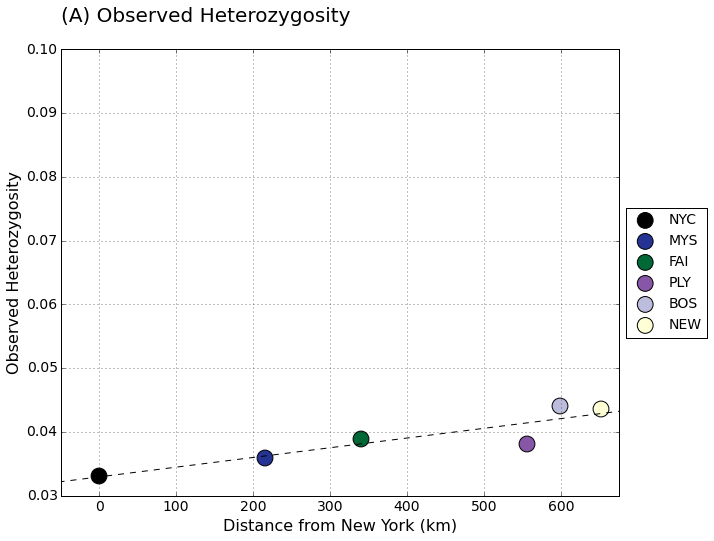

In [61]:
##Plotting Hobs

plot_genetic_statistic_with_regression(n3M3_p5_r60_sumstats_summary_df, 'distance', 'Hobs', 'Distance from New York (km)', 'Observed Heterozygosity', colors, '(A) Observed Heterozygosity', '/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/Hobs_vs_dist_n3M3p5r60_corrected.pdf', legend_location='upper right', ymax = 0.1, ymin = 0.03, xmax = 675, xmin = -50)

#plt.savefig('/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/Hobs_vs_dist_n3M3p5r60_corrected.eps', format='eps', dpi=1000, bbox_inches = 'tight')

('r-squared:', 0.10330002079869831)
('p-value:', 0.53449566999622922)


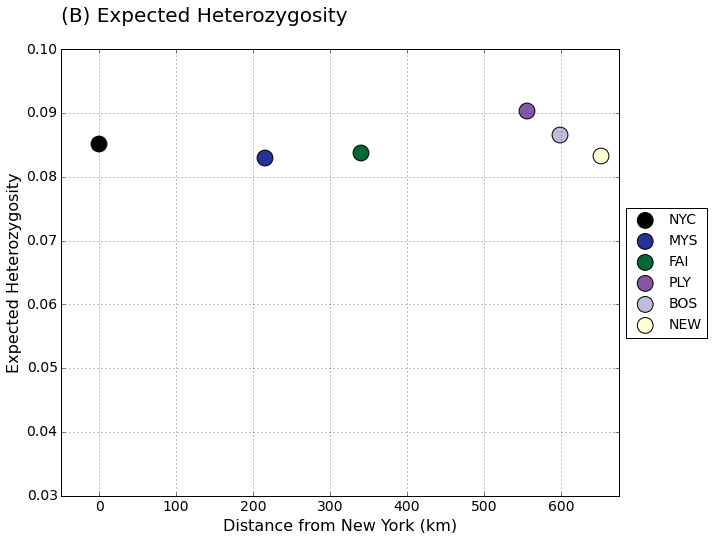

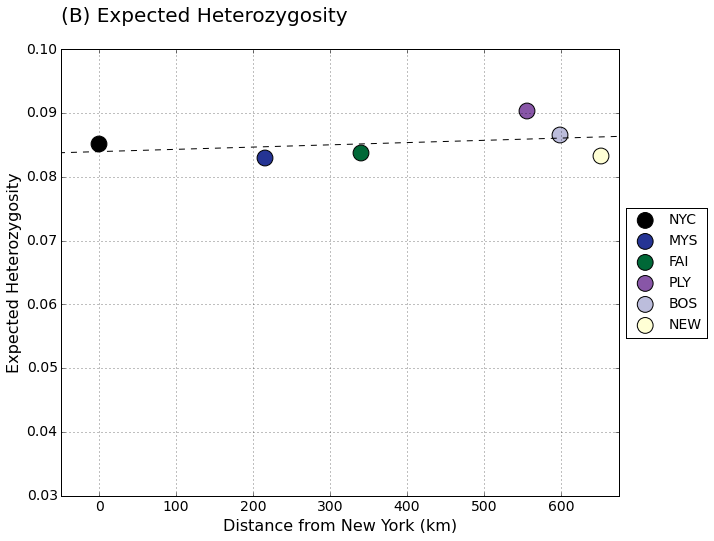

In [58]:
##Plotting Hexp -- done with two different functions: one with a regression and one without. 

plot_genetic_statistic_NO_regression(n3M3_p5_r60_sumstats_summary_df, 'distance', 'Hexp', 'Distance from New York (km)', 'Expected Heterozygosity', colors, '(B) Expected Heterozygosity', '/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/Hexp_vs_dist_n3M3p5r60_corrected.eps', legend_location='lower right', ymax = 0.1, ymin = 0.03, xmax = 675, xmin = -50)
plot_genetic_statistic_with_regression(n3M3_p5_r60_sumstats_summary_df, 'distance', 'Hexp', 'Distance from New York (km)', 'Expected Heterozygosity', colors, '(B) Expected Heterozygosity', '/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/Hexp_vs_dist_n3M3p5r60_with_regression_corrected.eps', legend_location='lower right', ymax = 0.1, ymin = 0.03, xmax = 675, xmin = -50)


('r-squared:', 0.15735485133329616)
('p-value:', 0.4361900676834396)


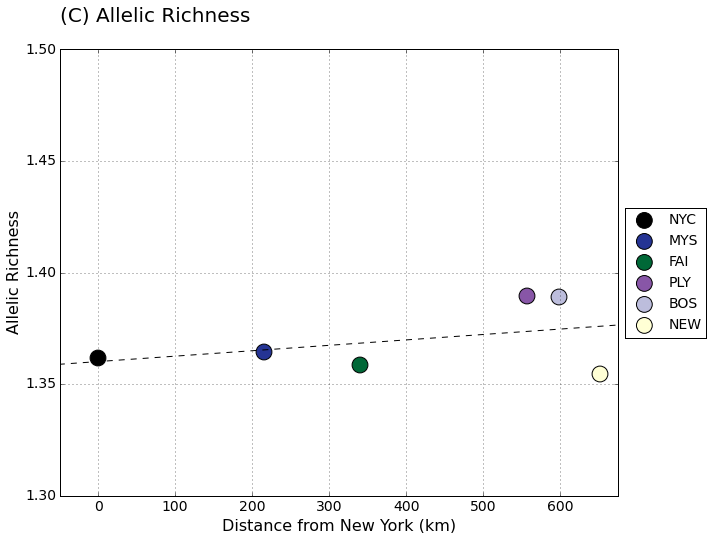

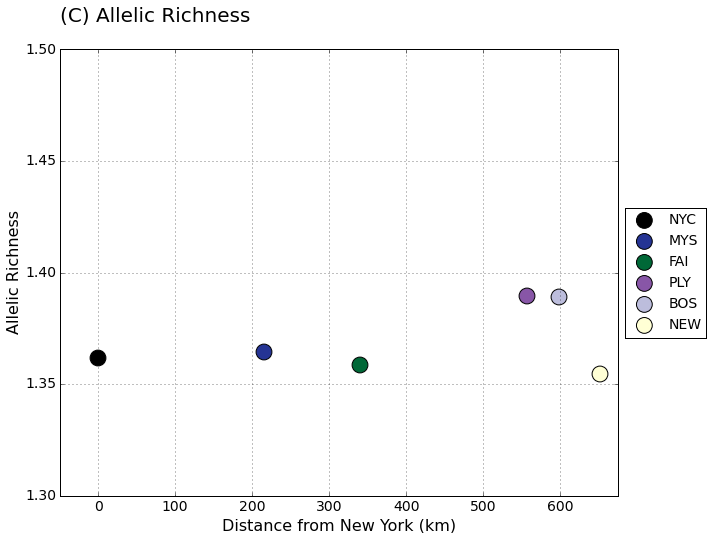

In [59]:

##Plotting ARich

plot_genetic_statistic_with_regression(n3M3_p5_r60_sumstats_summary_df, 'distance', 'a_richness', 'Distance from New York (km)', 'Allelic Richness', colors, '(C) Allelic Richness', '/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/A_rich_vs_dist_n3M3p5r60_with_regression_corrected.eps', legend_location='upper right', ymax = 1.5, ymin = 1.3, xmax = 675, xmin = -50)
plot_genetic_statistic_NO_regression(n3M3_p5_r60_sumstats_summary_df, 'distance', 'a_richness', 'Distance from New York (km)', 'Allelic Richness', colors, '(C) Allelic Richness', '/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/A_rich_vs_dist_n3M3p5r60_NO_regression_corrected.eps', legend_location='upper right', ymax = 1.5, ymin = 1.3, xmax = 675, xmin = -50)


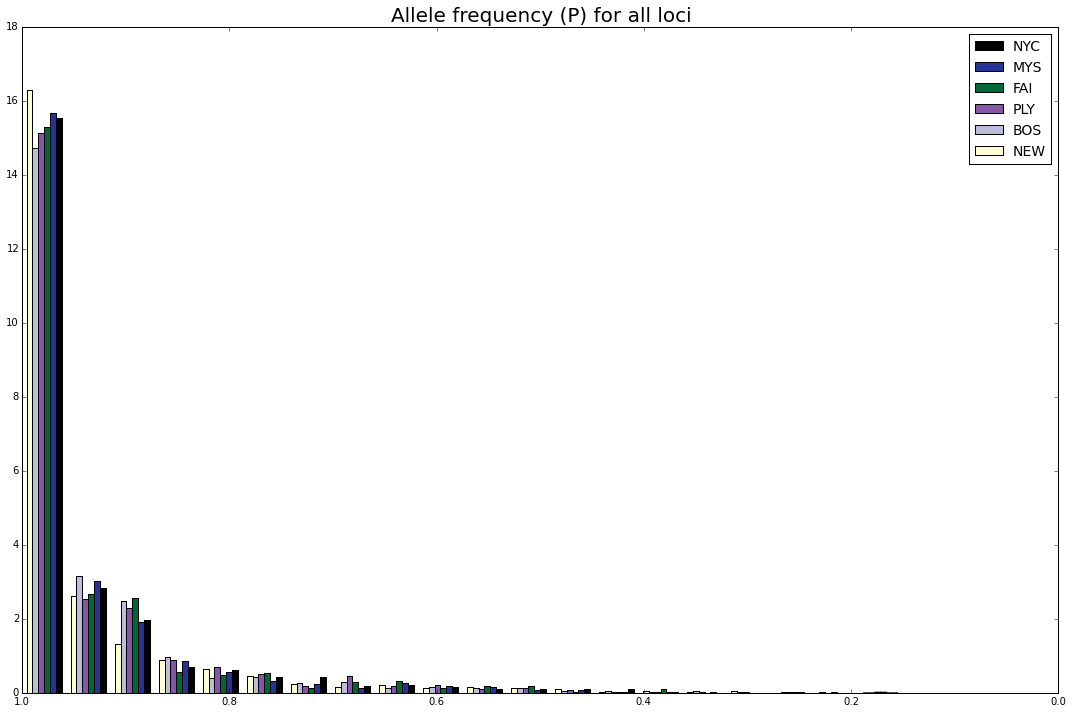

In [29]:
#GRAPH SITE FREQUENCY SPECTRA FOR VARIOUS OPTIONS OF DATAFRAME 
##Note that "colors" and "population_list" are defined at the top of the scripts

n_bins = 20
x = np.random.randn(1000, 3)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

colors = {'NYC': 'black', 'MYS':'#253494', 'FAI':'#006837', 'PLY':'#8856A7', 'BOS':'#BCBDDC', 'NEW': '#FFFFD5'}

#Make a color list from dictionary in the appropriate order 
color_list = []
for i in population_list:
    new_color = colors[i]
    color_list.append(new_color)


# Make a multiple-histogram of data-sets with different length.
x_multi = [n3M3_corrected_p5_r60_sumstats_df [n3M3_corrected_p5_r60_sumstats_df['pop'] == pop].P for pop in population_list]
ax.hist(x_multi, n_bins, histtype='bar', color = color_list,label = population_list, normed = True)

ax.set_title('Allele frequency (P) for all loci', fontsize=20)

ax.legend(loc='upper right', fontsize=14, scatterpoints=1)

#TO ONLY SHOW THE ONES UP TO 0.5 (so just ignore those that wouldn't be in ther other graph )
#ax.set_xlim(0, 0.5)
plt.xlim(1,0)
plt.tight_layout()
plt.show()
#fig.savefig('/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/SFS_n3M3_p5_r60_corrected.eps', format='eps', dpi=1000)

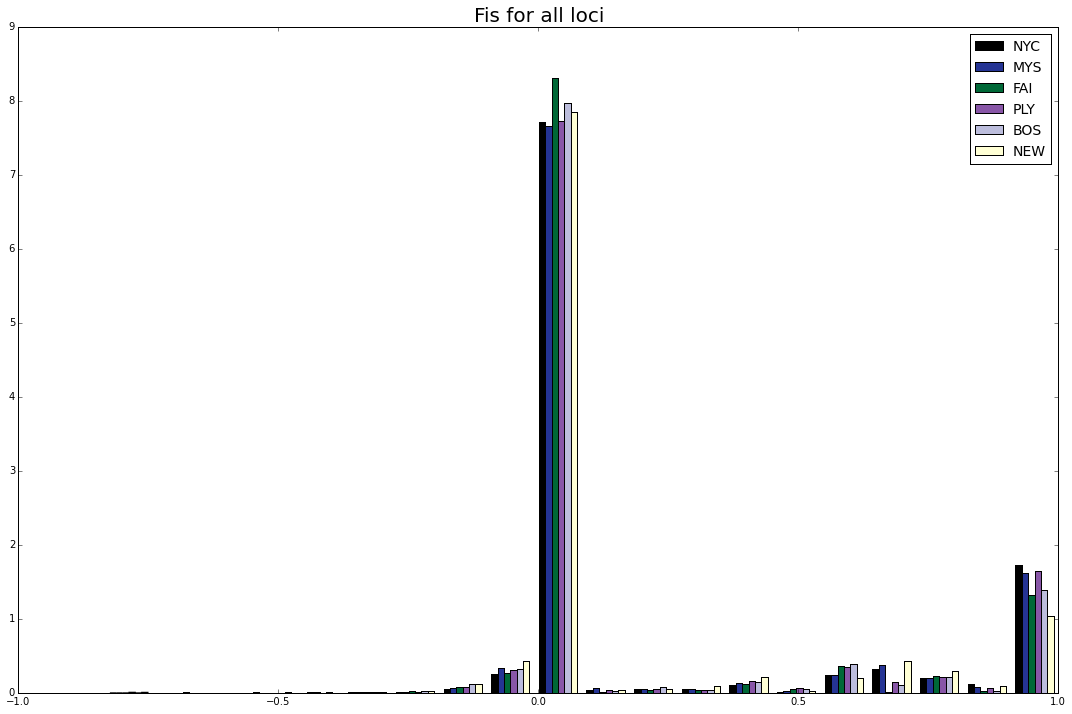

In [26]:
#GRAPH SITE FREQUENCY SPECTRA FOR VARIOUS OPTIONS OF DATAFRAME 
##Note that "colors" and "population_list" are defined at the top of the scripts

n_bins = 20
x = np.random.randn(1000, 3)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

colors = {'NYC': 'black', 'MYS':'#253494', 'FAI':'#006837', 'PLY':'#8856A7', 'BOS':'#BCBDDC', 'NEW': '#FFFFD5'}

#Make a color list from dictionary in the appropriate order 
color_list = []
for i in population_list:
    new_color = colors[i]
    color_list.append(new_color)


# Make a multiple-histogram of data-sets with different length.
#x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
x_multi = [n3M3_corrected_p5_r60_sumstats_df [n3M3_corrected_p5_r60_sumstats_df['pop'] == pop].Fis for pop in population_list]
ax.hist(x_multi, n_bins, histtype='bar', color = color_list,label = population_list, normed=True)

ax.set_title('Fis for all loci', fontsize=20)

ax.legend(loc='upper right', fontsize=14, scatterpoints=1)

#TO ONLY SHOW THE ONES UP TO 0.5 (so just ignore those that wouldn't be in ther other graph )
#ax.set_xlim(0, 0.5)
plt.xlim(-1,1)
plt.tight_layout()
plt.show()
fig.savefig('/Users/eleanorbors/Desktop/Manuscripts/Shrimp_MS/figures/Fis_n3M3_p5_r60_corrected.eps', format='eps', dpi=1000)